# Title

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams
from string import ascii_lowercase
import ipywidgets
import time

import discretize
from SimPEG import (
    Utils, Maps, Inversion, Regularization, DataMisfit, InvProblem,
    Optimization, Directives
)
from SimPEG import DC
from SimPEG.EM import TDEM
from pymatsolver import Pardiso

import casingSimulations as casingSim

%matplotlib inline

In [2]:
rcParams['font.size'] = 14

In [3]:
sim_dir = 'DC_halfspace'

## Model

- approximate the casing as a solid cylinder, conductivity equals to the conductivity thickness product
- use effective medium theory to estimate the conductivity of the target

In [4]:
# casing parameters
casing_l = 1000
sigma_back = 1e-2
casing_d = 10e-2
casing_t = 1e-2
sigma_casing = 5e6

sigma_casing_homogenized = sigma_casing * np.pi*((casing_d/2)**2 - (casing_d/2 - casing_t)**2)
print('The conductivity of the cylinder is {:1.2e} S/m'.format(sigma_casing_homogenized))

The conductivity of the cylinder is 1.41e+04 S/m


In [5]:
# proppant-fluid parameters
sigma_proppant = 1e4
sigma_fluid = 3
phi_proppant = 0.5

In [6]:
scemt = Maps.SelfConsistentEffectiveMedium(sigma0=sigma_fluid, sigma1=sigma_proppant)
sigma_pf = (scemt * np.r_[phi_proppant])[0]
print('The conductivity of the proppant-fluid mixture is {:1.2f} S/m'.format(sigma_pf))

The conductivity of the proppant-fluid mixture is 2506.73 S/m


In [7]:
# fracture geometry
n_fracs = 10
fracture_thickness = 3e-3
fracture_width = 10. # 10m wide fracture zone
fracture_radius = 50.
fracture_top = -950.

In [8]:
V_total = np.pi * fracture_radius**2 * fracture_width 
V_frac = np.pi * fracture_radius**2 * fracture_thickness*n_fracs
phi_frac = V_frac/V_total

print("The concentration of fractures by volume is {}".format(phi_frac))

The concentration of fractures by volume is 0.003


In [9]:
alpha = (fracture_thickness*0.5)/50

print("We assume an aspect ratio of {}".format(alpha))

We assume an aspect ratio of 3e-05


In [10]:
scemt_fractures = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha
)

In [11]:
sigma_frac = (scemt_fractures * np.r_[phi_frac])[0]
print('The conductivity of the fractured region of rock is {:1.2f} S/m'.format(sigma_frac))

The conductivity of the fractured region of rock is 3.31 S/m


In [12]:
model = casingSim.model.CasingInHalfspaceWithTarget(
    directory=sim_dir,
    sigma_casing= sigma_casing_homogenized,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_casing_homogenized,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    sigma_target = sigma_frac,  # conductivity of the fractured region
    casing_d = casing_d-casing_d/2,  # 10 cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_d/4, 
    target_radius = np.r_[0., fracture_radius],
    target_z = fracture_top + np.r_[-fracture_width, 0.],
    src_a = np.r_[0., np.pi, -975.],  # put the A electrode just below the surface
    src_b = np.r_[2000., np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

In [13]:
model.serialize()

{'__class__': 'CasingInHalfspaceWithTarget',
 'casing_d': 0.05,
 'casing_l': 1000.0,
 'casing_t': 0.025,
 'casing_top': 0.0,
 'directory': 'DC_halfspace',
 'filename': 'ModelParameters.json',
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_air': 0.0001,
 'sigma_back': 0.01,
 'sigma_casing': 14137.166941154077,
 'sigma_inside': 14137.166941154077,
 'sigma_target': 3.306452089817292,
 'src_a': [0.0, 3.141592653589793, -975.0],
 'src_b': [2000.0, 3.141592653589793, -1.25],
 'surface_z': 0.0,
 'target_radius': [0.0, 50.0],
 'target_theta': [0.0, 6.283185307179586],
 'target_z': [-960.0, -950.0],
 'version': '0.0.6'}

In [14]:
copied_model_params = copiedmodelparams = {
    key: val for key, val in model.serialize().items() 
    if key in dir(casingSim.model.CasingInHalfspace) and not key.startswith('_') 
}
background = casingSim.model.CasingInHalfspace(**copied_model_params)

In [15]:
model_names = ["background", "fracture"]
model_dict = {
    "background": background, 
    "fracture": model
}

## Mesh

In [16]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 1000  # go out 500m from the well

# padding parameters
npadx, npadz = 9, 16  # number of padding cells
pfx2 = 1.5  # expansion factor for the padding to infinity in the x-direction
pfz = 1.5

# discretization in theta
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(1)
hy = hy*2*np.pi / hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=sim_dir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_b/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx1=1.2, 
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)
mesh = cylMeshGen.mesh

In [17]:
print("The mesh has {} cells".format(mesh.nC))

The mesh has 43316 cells


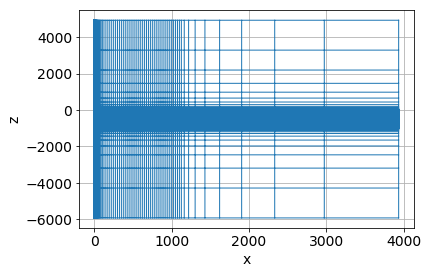

In [18]:
cylMeshGen.mesh.plotGrid()

## Physical Properties

In [19]:
phys_props_dict = {
    key: casingSim.model.PhysicalProperties(cylMeshGen, val) for key, val in model_dict.items()
}

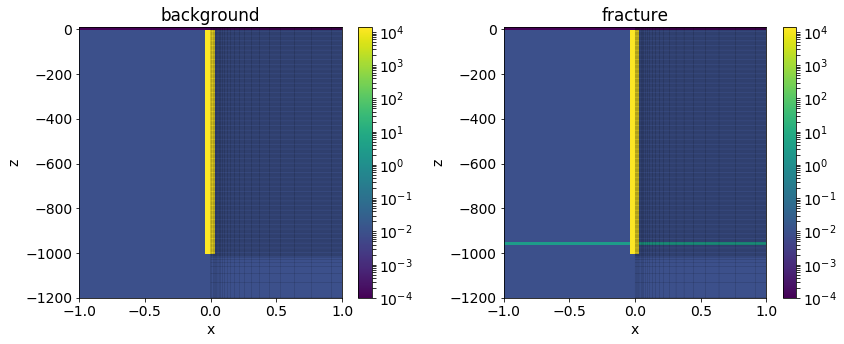

In [20]:
fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
xlim = 1*np.r_[-1, 1]
ylim = [-1200, 10]
plot_mesh = True

for a, key in zip(ax, model_names):
    phys_props_dict[key].plot_sigma(ax=a, pcolorOpts={'norm':LogNorm()})
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_title(key)

    if plot_mesh:
        mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
        a.grid(None)

plt.tight_layout()

## Survey

In [21]:
rx_x = np.linspace(25, 1000, 40)
rx_z = np.r_[-1.25]  # slightly below the surface for better interpolation 
rx_locs = Utils.ndgrid([rx_x, np.r_[0], rx_z])

rx_list = [DC.Rx.BaseRx(rx_locs, 'ex')]

In [22]:
include_obswell = True

if include_obswell is True:
    rx2_x = np.r_[250.]
    rx2_z = np.linspace(-1000, -25, 40)
    rx2_locs = Utils.ndgrid([rx2_x, np.r_[0.], rx2_z])
    
    rx_list += [DC.Rx.BaseRx(rx2_locs, 'ez')]

In [23]:
experiment = 2

if experiment == 1:
    z_locs = np.r_[-975] + cylMeshGen.csz/2
    src_a = np.atleast_2d(model.src_a)
    src_a[0, 2] = z_locs[0]
    src_b = np.atleast_2d(model.src_b)
    
elif experiment == 2:
    z_locs = -1*np.linspace(25, 975, 20) + cylMeshGen.csz/2
    src_a = np.vstack([np.r_[model.src_a[0], model.src_a[1], z] for z in z_locs])
    src_b = np.kron(np.ones((len(z_locs), 1)), model.src_b)

elif experiment == 3:
    z_locs = -1*np.linspace(25, 1000, 40) + cylMeshGen.csz/2
    src_a = np.vstack([np.r_[model.src_a[0], model.src_a[1], z] for z in z_locs])
    src_b = np.kron(np.ones((len(z_locs), 1)), model.src_b)

elif experiment == 4:
    z_locs = -1*np.linspace(900, 1000, 10) + cylMeshGen.csz/2
    src_a = np.vstack([np.r_[model.src_a[0], model.src_a[1], z] for z in z_locs])
    src_b = np.kron(np.ones((len(z_locs), 1)), model.src_b)

In [24]:
src_list = [DC.Src.Dipole(rx_list, locA=src_a[i, :], locB=src_b[i, :]) for i in range(len(z_locs))]

## Set up a DC simulation

In [25]:
prob_dict = {}
survey_dict = {}

for key in model_names:
    prob_dict[key] = DC.Problem3D_CC(
        mesh, sigmaMap=Maps.ExpMap(mesh), bc_type='Dirichlet', Solver=Pardiso
    )
    survey_dict[key] = DC.Survey(src_list)
    prob_dict[key].pair(survey_dict[key]) 

Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [26]:
%%time
fields_dict = {}
for key in model_names:
    t = time.time()
    print('Running {}'.format(key))
    fields_dict[key] = prob_dict[key].fields(np.log(phys_props_dict[key].sigma))
    print('  ... elapsed time {:1.2e} s\n'.format(time.time()-t))

Running background
  ... elapsed time 4.55e-01 s

Running fracture
  ... elapsed time 3.20e-01 s

CPU times: user 1.18 s, sys: 97.6 ms, total: 1.28 s
Wall time: 775 ms


In [27]:
%%time
data_dict = {}
for key in model_names:
    t = time.time()
    print('Computing data for {}'.format(key))
    data_dict[key] = survey_dict[key].dpred(
        np.log(phys_props_dict[key].sigma), f=fields_dict[key]
    )
    print('  ... elapsed time {:1.2e} s\n'.format(time.time()-t))

Computing data for background
  ... elapsed time 3.62e-01 s

Computing data for fracture
  ... elapsed time 2.64e-01 s

CPU times: user 576 ms, sys: 111 ms, total: 687 ms
Wall time: 627 ms


In [28]:
def wrangle_data(data, component="x"):
    d = data.reshape(src_list[0].nD, len(src_list), order="F")
    if component == "x": 
        dx = d[:src_list[0].rxList[0].nD, :] 
        return dx
    
    if include_obswell and component == "z":
        dz = d[src_list[0].rxList[0].nD:, :]
        return dz
        
    data_dict[key] = entry

In [29]:
for key, value in data_dict.items():
    entry = {
        "data": value,
        "data_x": wrangle_data(value, "x")
    }
    if include_obswell:
        entry["data_z"] = wrangle_data(value, "z")
    data_dict[key] = entry

## Plot data

In [30]:
def plot_models(
    model, mapping, xlim=80*np.r_[-1, 1], ylim=[-1050, -800], 
    clim=None, plot_mesh=False, ax=None
):
    
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))    

    out_true = phys_props_dict["fracture"].plot_sigma(
        ax=ax[0], pcolorOpts={'norm':LogNorm()}, clim=np.r_[sigma_back, sigma_frac]
    )
    
    if clim is None:
        clim = [np.min(np.r_[sigma_back, np.exp(mrec.min())]), np.exp(mrec.max())]
        
    out_rec = phys_props_dict["fracture"].plot_prop(
        mapping * model, ax=ax[1], pcolorOpts={'norm':LogNorm()}, clim=clim
    )

    ax[0].set_title("true")
    ax[1].set_title("recovered")

    for a in ax:
        a.set_xlim(xlim)
        a.set_ylim(ylim)

        if plot_mesh:
            mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
            a.grid(None)

    plt.tight_layout()
    
    return (ax, out_true, out_rec)

In [31]:
def plot_data(
    dobs, dpred, plot_percentage=False, label_obs="dobs", label_pred="dpred", 
    ax=None, plot_style="plot", component='x'
):
    if ax is None:
        nplots = 2 + plot_percentage
        fig, ax = plt.subplots(nplots, 1, figsize=(6, nplots*3))
    else: 
        [a.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) for a in ax[:2]]
    
    x = rx_x if component == "x" else rx2_z
    
    for i in range(len(src_list)):
        getattr(ax[0], plot_style)(
            x, np.abs(dobs[:, i]) if plot_style in ["loglog", "semilogy"] else dobs[:, i], 
            'o', ms=2, label=label_obs if i==0 else None, color="C{}".format(np.mod(i, 10))
        )
        getattr(ax[0], plot_style)(
            x, np.abs(dpred[:, i]) if plot_style in ["loglog", "semilogy"] else dpred[:, i], 
            lw=1, label=label_pred if i==0 else None, color="C{}".format(np.mod(i, 10))
        )
        getattr(ax[1], plot_style)(
            x, dpred[:, 1] - dobs[:, i]
        )
        
        if plot_percentage: 
            ax[2].plot(rx_x, 100*np.absolute(dpred[:, i] - dobs[:, i])/dobs[:, i])
            ax[2].set_ylabel('secondary $E_{}$ (%)'.format("r" if component == "x" else component))

    ax[0].set_ylabel('$E_{}$'.format("r" if component == "x" else component))
    ax[0].legend()

    ax[0].set_ylabel('measured $E_{}$'.format("r" if component == "x" else component))
    ax[1].set_ylabel('secondary $E_{}$'.format("r" if component == "x" else component))
    

    for i, a in enumerate(ax):
        a.grid(which="both", alpha=0.4, lw=0.5) 
        a.set_xlabel("{}".format("offset (m)" if component=="x" else "{} (m)".format(component)))
        a.set_title('({})'.format(ascii_lowercase[i]))

    plt.tight_layout()

    return ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0xd1c589e48>,
      dtype=object)

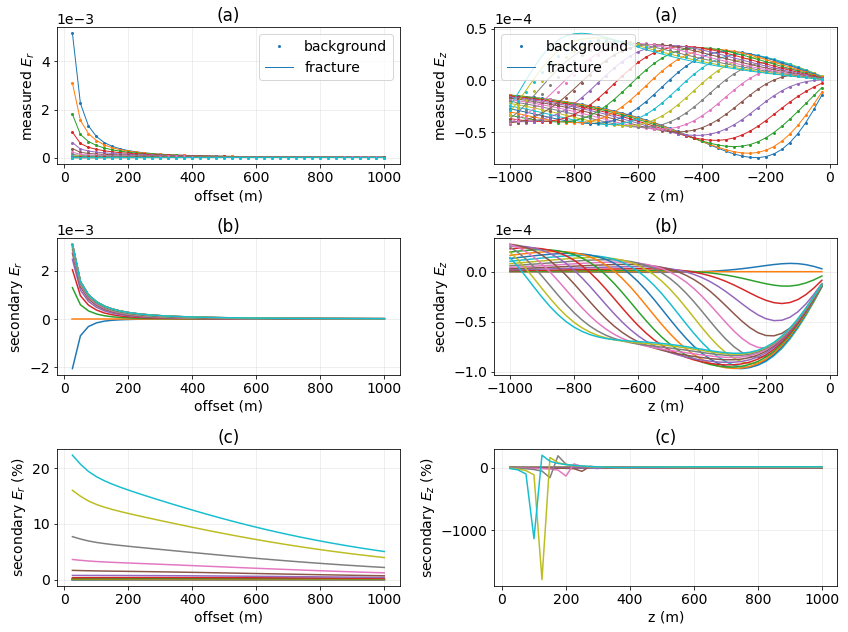

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(2*6, 3*3))
plot_data(
    data_dict["background"]["data_x"], data_dict["fracture"]["data_x"], 
    True, label_obs="background", label_pred="fracture", plot_style="plot",
    ax=ax[:, 0]
)

plot_data(
    data_dict["background"]["data_z"], data_dict["fracture"]["data_z"], 
    True, label_obs="background", label_pred="fracture", plot_style="plot",
    ax=ax[:, 1], component="z"
)

## Set up an inversion

In [33]:
STD = 0.01
EPS = 1e-9
CHIFACT = 0.05

In [34]:
# Construct mapping
ExpMap = Maps.ExpMap(mesh)
ind_inactive = (
    (mesh.gridCC[:,2] > 0) | 
    (
        (mesh.gridCC[:, 0] <= model.casing_b) & 
        (mesh.gridCC[:, 2] >= model.casing_z.min()) &
        (mesh.gridCC[:, 2] <= model.casing_z.max())
    )
)
sigma_inactive = phys_props_dict["background"].sigma[ind_inactive]
InjectInactiveCells = Maps.InjectActiveCells(mesh, ~ind_inactive, np.log(sigma_inactive))
mapping = ExpMap * InjectInactiveCells

In [35]:
def get_prob_survey(mapping):
    prob_inv = DC.Problem3D_CC(
        mesh, sigmaMap=mapping, bc_type='Dirichlet', Solver=Pardiso
    )
    survey_inv = DC.Survey(src_list)
    prob_inv.pair(survey_inv)
    
#     d = discretize.utils.mkvc(np.vstack(data_dict["fracture"]))
    survey_inv.dobs = data_dict["fracture"]["data"]
    survey_inv.std = STD
    survey_inv.eps = EPS
    
    return prob_inv, survey_inv

In [36]:
prob_inv, survey_inv = get_prob_survey(mapping)

Homogeneous Dirichlet is the natural BC for this CC discretization.


## Plot the sensitivity

In [37]:
def plot_sensitivity(Jlist, xlim=100*np.r_[-1, 1], ylim=np.r_[-1200, 0], clim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, len(Jlist), figsize=(6*len(Jlist), 6))
    
    Jlist = [J.sum(0) for J in Jlist]
    if clim is None:
        Jmax = np.abs(np.hstack(Jlist)).max()
        clim = Jmax*np.r_[-1, 1]
    
    for a, J in zip(ax, Jlist): 
        cbar = plt.colorbar(mesh.plotImage(
            Maps.InjectActiveCells(mesh, ~ind_inactive, 0) * J, ax=a,
            mirror=True, clim=clim
        )[0], ax=a)
        a.set_xlim(xlim)
        a.set_ylim(ylim)
    
    plt.tight_layout()

    return ax
    

In [38]:
prob_inv.model = np.ones((~ind_inactive).sum())*sigma_back
J_l2_m0 = prob_inv.getJ(np.ones((~ind_inactive).sum())*sigma_back)
                        
prob_inv.model = np.log(model.sigma(mesh)[~ind_inactive])
J_l2_target = prob_inv.getJ(np.log(model.sigma(mesh)[~ind_inactive]))

array([<matplotlib.axes._subplots.AxesSubplot object at 0xd29b47f60>,
      dtype=object)

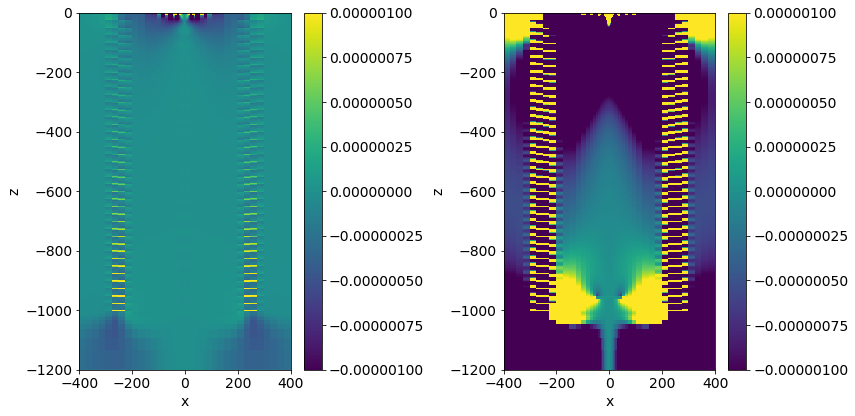

In [39]:
plot_sensitivity([J_l2_m0, J_l2_target], clim=1e-6*np.r_[-1, 1], xlim=400*np.r_[-1., 1.])

## Run the inversion

In [40]:
regmesh = discretize.TensorMesh([mesh.hx, mesh.hz], x0=np.r_[mesh.x0[[0, 2]]])
reg = Regularization.Tikhonov(regmesh, alpha_s=1e-3, indActive=~ind_inactive)
dmis = DataMisfit.l2_DataMisfit(survey_inv)
opt = Optimization.InexactGaussNewton(maxIterCG=10, maxIter=10, remember='xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=10),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
#     Directives.SaveModelEveryIteration(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv = Inversion.BaseInversion(invProb, directiveList=directives)

In [41]:
m0 = np.log(sigma_back * np.ones(mapping.nP))

In [42]:
%%time
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.46e+01  4.57e+05  0.00e+00  4.57e+05    8.70e+05      0              
   1  1.46e+01  1.19e+04  2.09e-01  1.19e+04    7.74e+04      0              
   2  1.46e+01  3.13e+03  3.26e-01  3.14e+03    7.22e+03      0   Skip BFGS  
   3  1.83e+00  4.49e+02  5.81e-01  4.50e+02    6.41e+03      0   Skip BFGS  
   4  1.83e+00  2.00e+02  8.91e-01  2.02e+02    3.49e+03      0              
   5  1.83e+00  1.57e+02  1.04e+00  1.59e+02    6.80e+02      0   Skip BFGS  
   6  2.29e-01  1.36e+02  1.04e+00  1.36e+02    7.13e+03      0   

(array([<matplotlib.axes._subplots.AxesSubplot object at 0xd29d847f0>,
       dtype=object),
 (<matplotlib.collections.QuadMesh at 0xd29b2b978>,
  <matplotlib.colorbar.Colorbar at 0xd2c892ba8>),
 (<matplotlib.collections.QuadMesh at 0xd2c8b0048>,
  <matplotlib.colorbar.Colorbar at 0xd4d931630>))

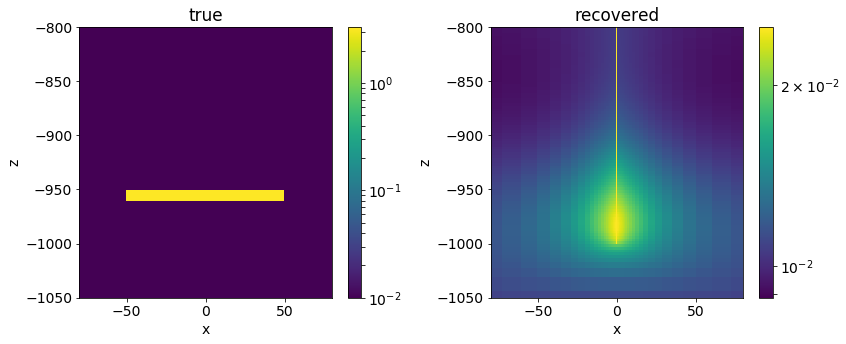

In [43]:
plot_models(mrec, mapping) #, xlim=200*np.r_[-1, 1], ylim=np.r_[-2000, 0])

array([<matplotlib.axes._subplots.AxesSubplot object at 0xd2be68be0>,
      dtype=object)

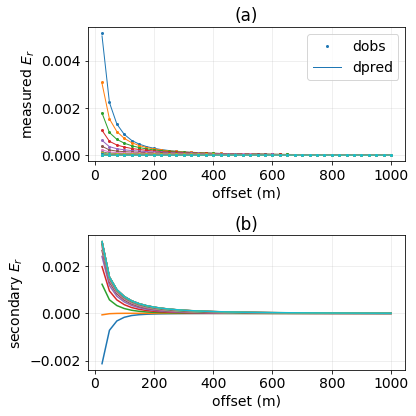

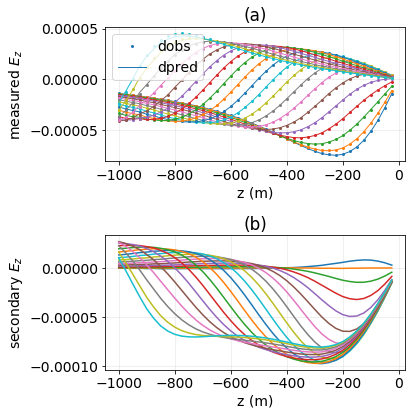

In [44]:
plot_data(data_dict["fracture"]["data_x"], wrangle_data(invProb.dpred, "x"))

plot_data(data_dict["fracture"]["data_z"], wrangle_data(invProb.dpred, "z"), component="z")

## L2 inversion on uniformly spaced mesh

In [45]:
casing_region = regmesh.hx[regmesh.hx < cylMeshGen.csz].sum()
ncells = int(np.ceil(casing_region/cylMeshGen.csz))
casing_region_h = np.ones(ncells) * casing_region/ncells

regmesh2 = discretize.TensorMesh(
    [
        np.hstack([casing_region_h, regmesh.hx[regmesh.hx >= cylMeshGen.csz]]), 
        regmesh.hy[regmesh.vectorCCy <= 0]
    ],
    x0=np.r_[0., -regmesh.hy[regmesh.vectorCCy <= 0].sum()]
)


In [48]:
mesh2mesh = Maps.Mesh2Mesh([regmesh, regmesh2], indActive = np.where(~ind_inactive)[0])
mapping2 = ExpMap * InjectInactiveCells * mesh2mesh

ValueError: Dimension mismatch in ComboMap[ExpMap(43316,43316) * InjectActiveCells(43316,39658)](43316,39658) and Mesh2Mesh(816513853,28207).

In [ ]:
prob_inv2, survey_inv2 = get_prob_survey(mapping2)

In [ ]:
reg2 = Regularization.Tikhonov(regmesh2, alpha_s=1e-3)
dmis2 = DataMisfit.l2_DataMisfit(survey_inv2)
opt2 = Optimization.InexactGaussNewton(maxIterCG=10, maxIter=5, remember='xc')
invProb2 = InvProblem.BaseInvProblem(dmis2, reg2, opt2)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=10),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
#     Directives.SaveModelEveryIteration(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv2 = Inversion.BaseInversion(invProb2, directiveList=directives)

In [ ]:
m02 = np.ones(regmesh2.nC) * np.log(sigma_back)

In [ ]:
%%time
mrec2 = inv2.run(m02)

In [ ]:
plot_models(mrec2, mapping2, xlim=80*np.r_[-1, 1])

In [ ]:
dpred2 = invProb2.dpred.reshape(len(rx_x), len(src_list), order="F")
plot_data(data_dict["fracture"], dpred2)

## sparse inversion

In [49]:
# regmesh = discretize.TensorMesh([mesh.hx, mesh.hz], x0=np.r_[mesh.x0[[0, 2]]])
# reg = Regularization.Tikhonov(regmesh, alpha_s=1e-1, indActive=~ind_inactive)
reg_sparse = Regularization.Sparse(
    regmesh, indActive=~ind_inactive,
    gradientType='components', 
    mapping=Maps.IdentityMap(nP=(~ind_inactive).sum()),
    alpha_s=1e-3
)
# reg_sparse.cell_weights = regmesh.vol[~ind_inactive]
#     gradientType = 'components'
reg_sparse.norms = np.c_[1., 2., 2., 2.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=10, minGNiter=1,
    betaSearch=True, fix_Jmatrix=False, 
    chifact_start=CHIFACT, beta_ratio_l2=10, 
    coolingFactor=8, coolingRate=3
)
update_sensitivity = Directives.UpdateSensitivityWeights(threshold=1e-3)
dmis_sparse = DataMisfit.l2_DataMisfit(survey_inv)
opt_sparse = Optimization.InexactGaussNewton(maxIterCG=10, maxIter=10, remember='xc')
invProb_sparse = InvProblem.BaseInvProblem(dmis_sparse, reg_sparse, opt_sparse)
directives_sparse = [
    IRLS,
    update_sensitivity, 
    Directives.UpdatePreconditioner(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_sparse = Inversion.BaseInversion(invProb_sparse, directiveList=directives_sparse)

In [ ]:
%%time
mrec_sparse = inv_sparse.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  4.57e+05  0.00e+00  4.57e+05    8.70e+05      0              


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(6*3, 5))
xlim = 80*np.r_[-1, 1]
ylim = [-1050, -800]
clim = [np.min(np.r_[sigma_back, np.exp(mrec_sparse.min())]), np.exp(mrec_sparse.max())]
plot_mesh = False

out_true = phys_props_dict[key].plot_sigma(
    ax=ax[0], pcolorOpts={'norm':LogNorm()}, clim=np.r_[sigma_back, sigma_frac]
)
out_rec = phys_props_dict[key].plot_prop(
    mapping * invProb_sparse.l2model, ax=ax[1], pcolorOpts={'norm':LogNorm()}, clim=clim
)
out_rec = phys_props_dict[key].plot_prop(
    mapping * mrec_sparse, ax=ax[2], pcolorOpts={'norm':LogNorm()}, clim=clim
)

for a, title in zip(ax, ["true", "l2", "sparse\n{}".format(reg_sparse.norms[0, :])]):
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_title(title)

    if plot_mesh:
        mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
        a.grid(None)

plt.tight_layout()

In [ ]:
dpred_sparse = invProb_sparse.dpred.reshape(len(rx_x), len(src_list), order="F")
plot_data(data_dict["fracture"], dpred_sparse)

## Parametric inversion

- block in a halfspace
- ellipsoid? 

In [ ]:
# mapping_parametric
ExpMap = Maps.ExpMap(mesh)
ind_inactive = (
    (mesh.gridCC[:,2] > 0) | 
    (
        (mesh.gridCC[:, 0] <= model.casing_b) & 
        (mesh.gridCC[:, 2] >= model.casing_z.min()) &
        (mesh.gridCC[:, 2] <= model.casing_z.max())
    )
)
sigma_inactive = phys_props_dict["background"].sigma[ind_inactive]
InjectInactiveCells = Maps.InjectActiveCells(mesh, ~ind_inactive, np.log(sigma_inactive))
ParametricBlock = Maps.ParametricBlock(regmesh, indActive=~ind_inactive, slopeFact=1e-2)
indActiveX0= np.ones(ParametricBlock.nP, dtype=bool)
indActiveX0[2] = False
InjectX0 = Maps.InjectActiveCells(
    discretize.TensorMesh([np.ones(ParametricBlock.nP)]), indActive=indActiveX0,
    valInactive=0.
)
mapping_parametric = ExpMap * InjectInactiveCells * ParametricBlock * InjectX0

In [ ]:
m0_parametric = np.r_[np.log(sigma_back), np.log(sigma_back*10), 20., -960., 5.]

In [ ]:
out = plot_models(m0_parametric, mapping_parametric, clim=[np.min(np.r_[sigma_back, np.exp(m0_parametric[:2].min())]), np.exp(m0_parametric[:2].max())])
out[0][1].set_title("starting")

In [ ]:
prob_parametric, survey_parametric = get_prob_survey(mapping_parametric)

In [ ]:
mback_parametric = np.r_[np.log(sigma_back), np.log(sigma_back), 100., -955, 10]
prob_parametric.model = mback_parametric
J_parametric_background = prob_parametric.getJ(mback_parametric)
                
mtrue_parametric = np.r_[np.log(sigma_back), np.log(sigma_frac), 100., -955, 10]
prob_parametric.model = mtrue_parametric
J_parametric_target = prob_parametric.getJ(mtrue_parametric)

In [ ]:
J_parametric_background.sum(0), J_parametric_target.sum(0)

In [ ]:
# regmesh = discretize.TensorMesh([mesh.hx, mesh.hz], x0=np.r_[mesh.x0[[0, 2]]])
reg_parametric = Regularization.Tikhonov(discretize.TensorMesh([mapping_parametric.nP]))
dmis_parametric = DataMisfit.l2_DataMisfit(survey_parametric)
opt_parametric = Optimization.InexactGaussNewton(maxIterCG=5, maxIter=30, remember='xc')
invProb_parametric = InvProblem.BaseInvProblem(dmis_parametric, reg_parametric, opt_parametric, beta=0)
directives = [
#     Directives.SaveOutputEveryIteration(),
#     Directives.SaveModelEveryIteration(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_parametric = Inversion.BaseInversion(invProb_parametric, directiveList=directives)

In [ ]:
%%time
mrec_parametric = inv_parametric.run(m0_parametric)

In [ ]:
def print_parametric(m): 
    print(
        "sigma back   : {:1.2e} S/m\n"
        "sigma target : {:1.2e} S/m\n"
        "target radius: {:1.2f} m\n"
        "target top   : {:1.2f} m\n"
        "target_bottom: {:1.2f} m\n".format(
            np.exp(m[0]), np.exp(m[1]), 
            m[2],
            m[3] + m[4]/2, 
            m[3] - m[4]/2
        )
    )

In [ ]:
print_parametric(m0_parametric)

In [ ]:
print_parametric(mrec_parametric)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(6*3, 5))
xlim = 80*np.r_[-1, 1]
ylim = [-1050, -900]
clim_start = [np.min(np.r_[sigma_back, np.exp(m0_parametric[:2].min())]), np.exp(m0_parametric[:2].max())]
clim_rec = [np.min(np.r_[sigma_back, np.exp(mrec_parametric[:2].min())]), np.exp(mrec_parametric[:2].max())]
plot_mesh = False

out_true = phys_props_dict[key].plot_sigma(
    ax=ax[0], pcolorOpts={'norm':LogNorm()}, clim=np.r_[sigma_back, sigma_frac]
)
out_initial = phys_props_dict[key].plot_prop(
    mapping_parametric * m0_parametric, ax=ax[1], pcolorOpts={'norm':LogNorm()}, clim=clim_start
)
out_rec = phys_props_dict[key].plot_prop(
    mapping_parametric * mrec_parametric, ax=ax[2], pcolorOpts={'norm':LogNorm()}, clim=clim_rec
)

for a, title in zip(ax, ["true", "starting", "recovered"]):
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_title(title)

    if plot_mesh:
        mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
        a.grid(None)

plt.tight_layout()

In [ ]:
dpred_parametric = invProb_parametric.dpred.reshape(len(rx_x), len(src_list), order="F")

plot_data(data_dict["fracture"], dpred_parametric)

## SCEMT mapping

In [ ]:
scemt_mapping = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha, nP=(~ind_inactive).sum()
)

In [ ]:
phi_true = scemt_mapping.inverse(model.sigma(mesh)[~ind_inactive])

### L2 Inversion with SCEMT mapping

In [ ]:
mapping_scemt = Maps.InjectActiveCells(mesh, ~ind_inactive, sigma_inactive) * scemt_mapping

In [ ]:
prob_scemt, survey_scemt = get_prob_survey(mapping_scemt)

In [ ]:
prob_scemt.model = np.zeros((~ind_inactive).sum())
J_scemt_m0 = prob_scemt.getJ(prob_scemt.model)
                        
prob_scemt.model = phi_true
J_scemt_target = prob_scemt.getJ(prob_scemt.model)

In [ ]:
plot_sensitivity([J_scemt_m0, J_scemt_target], clim=1e-2*np.r_[-1, 1])

In [ ]:
reg_scemt = Regularization.Tikhonov(
    regmesh, alpha_s=1e-3, indActive=~ind_inactive, mref=np.zeros(mapping_scemt.nP)
)
dmis_scemt = DataMisfit.l2_DataMisfit(survey_scemt)
opt_scemt = Optimization.ProjectedGNCG(
    maxIterCG=10, maxIter=10, remember='xc', lower=0., upper=1., stepOffBoundsFact=1e-4
)
invProb_scemt = InvProblem.BaseInvProblem(dmis_scemt, reg_scemt, opt_scemt)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=10),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
#     Directives.SaveModelEveryIteration(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_scemt = Inversion.BaseInversion(invProb_scemt, directiveList=directives)

In [ ]:
m0_scemt = 1e-10 + np.zeros(mapping_scemt.nP)

In [ ]:
mrec_scemt = inv_scemt.run(m0_scemt)

In [ ]:
out = plot_models(
    mrec_scemt, mapping_scemt, 
    clim=np.r_[
        np.min(np.r_[sigma_back, (scemt_mapping * mrec_scemt).min()]), 
        (scemt_mapping * mrec_scemt).max()
    ], xlim=100*np.r_[-1, 1], ylim=np.r_[-2000, 10]
)

### SCEMT + Parametric

In [ ]:
# mapping_parametric
ind_inactive = (
    (mesh.gridCC[:,2] > 0) | 
    (
        (mesh.gridCC[:, 0] <= model.casing_b) & 
        (mesh.gridCC[:, 2] >= model.casing_z.min()) &
        (mesh.gridCC[:, 2] <= model.casing_z.max())
    )
)
sigma_inactive = phys_props_dict["background"].sigma[ind_inactive]
InjectInactiveCells = Maps.InjectActiveCells(mesh, ~ind_inactive, np.log(sigma_inactive))
ParametricBlock = Maps.ParametricBlock(regmesh, indActive=~ind_inactive, slopeFact=1e-1)
indActiveX0= np.ones(ParametricBlock.nP, dtype=bool)
indActiveX0[2] = False
InjectX0 = Maps.InjectActiveCells(
    discretize.TensorMesh([np.ones(ParametricBlock.nP)]), indActive=indActiveX0,
    valInactive=0.
)

indices_sigma = np.zeros(InjectX0.nP, dtype=bool)
indices_sigma[0:2] = True

SCEMT = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha, nP=2
)

sumMap = Maps.SumMap(
    [
        (
            Maps.InjectActiveCells(None, nC=InjectX0.nP, indActive=indices_sigma, valInactive=0) * 
            Maps.LogMap(nP=SCEMT.nP) * SCEMT * Maps.Projection(InjectX0.nP, indices_sigma)
        ),
        Maps.InjectActiveCells(None, nC=InjectX0.nP, indActive=~indices_sigma, valInactive=0) * Maps.Projection(InjectX0.nP, ~indices_sigma)
    ],
)

scemt_parametric_map = Maps.ExpMap(mesh) * InjectInactiveCells * ParametricBlock * InjectX0 * sumMap

# mapping_parametric = (
#     Maps.InjectActiveCells(mesh, ~ind_inactive, sigma_inactive) * ParametricBlock * InjectX0 * 
    
# )

In [ ]:
prob_scemt2, survey_scemt2 = get_prob_survey(scemt_parametric_map2)

In [ ]:
reg_parametric = Regularization.Tikhonov(discretize.TensorMesh([scemt_parametric_map.nP]))

dmis_scemt2 = DataMisfit.l2_DataMisfit(survey_scemt2)
opt_scemt2 = Optimization.ProjectedGNCG(
    maxIterCG=10, maxIter=10, remember='xc', 
    lower=np.hstack([2*[0.], 3*[-np.inf]]), upper=np.hstack([2*[1.], 3*[np.inf]]), stepOffBoundsFact=1e-4
)
invProb_scemt2 = InvProblem.BaseInvProblem(dmis_scemt2, reg_parametric, opt_scemt2, beta=0)
directives = [
#     Directives.BetaEstimate_ByEig(beta0_ratio=10),
#     Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
#     Directives.SaveModelEveryIteration(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_scemt2 = Inversion.BaseInversion(invProb_scemt2, directiveList=directives)

In [ ]:
m0_scemt_parametric = np.hstack([np.r_[1e-10, 1e-5], m0_parametric[2:]])

In [ ]:
plot_models(m0_scemt_parametric, scemt_parametric_map2, clim=np.r_[sigma_back, 1])

In [ ]:
scemt_parametric_map2.test(m0_scemt_parametric, dx=np.r_[1e-5, 1e-4, 5, 20, 10])

In [ ]:
mrec_scemt_parametric = inv_scemt2.run(m0_scemt_parametric)

In [ ]:
mrec_scemt_parametric

In [ ]:
plot_models(mrec_scemt_parametric, scemt_parametric_map2, clim=np.r_[sigma_back, 5])

## different order of operations (convert to phi on the mesh) 

In [ ]:
# mapping_parametric
ind_inactive = (
    (mesh.gridCC[:,2] > 0) | 
    (
        (mesh.gridCC[:, 0] <= model.casing_b) & 
        (mesh.gridCC[:, 2] >= model.casing_z.min()) &
        (mesh.gridCC[:, 2] <= model.casing_z.max())
    )
)
sigma_inactive = phys_props_dict["background"].sigma[ind_inactive]
InjectInactiveCells = Maps.InjectActiveCells(mesh, ~ind_inactive, sigma_inactive)
ParametricBlock = Maps.ParametricBlock(regmesh, indActive=~ind_inactive, slopeFact=1e-1)
indActiveX0= np.ones(ParametricBlock.nP, dtype=bool)
indActiveX0[2] = False
InjectX0 = Maps.InjectActiveCells(
    discretize.TensorMesh([np.ones(ParametricBlock.nP)]), indActive=indActiveX0,
    valInactive=0.
)

SCEMT2 = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha, nP=(~ind_inactive).sum()
)


scemt_parametric_map2 = InjectInactiveCells * SCEMT2 * ParametricBlock * InjectX0


## Include the volume term

In [ ]:
from SimPEG import Problem, Survey, Props


In [ ]:
class Volume(Problem.BaseProblem):
    # surveyPair = Survey.LinearSurvey
    
    phi, phi_map, phi_deriv = Props.Invertible(
        "concentration (unitless)"
    )
    
    def __init__(self, mesh, **kwargs):
        BaseProblem.__init__(self, mesh, **kwargs)

    def fields(self, m):
        return np.inner(self.mesh.vol, self.phi)

    def Jvec(self, m, v, f=None):
        return np.inner(self.mesh.vol, self.phi_deriv*v)

    def Jtvec(self, m, v, f=None):
        return np.inner(self.phi_deriv.T, self.mesh.vol*v )


In [ ]:
class ParametricVolume(Problem.BaseProblem):
    # surveyPair = Survey.LinearSurvey
    
    phi, phi_map, phi_deriv = Props.Invertible(
        "concentration (unitless)"
    )
    
    dx, dx_map, dx_deriv = Props.Invertible(
        "width in the x-dimension of the target"
    )
    
    dy, dy_map, dy_deriv = Props.Invertible(
        "width in the y-dimension of the target"
    )
    
    dz, dz_map, dz_deriv = Props.Invertible(
        "width in the z-dimension of the target"
    )
    
    def __init__(self, **kwargs):
        BaseProblem.__init__(self, None, **kwargs)

    def fields(self, m):
        return  self.dx * self.dy * self.dz * self.phi

    def Jvec(self, m, v, f=None):
        return (
            self.dx * self.dy * self.dz * (self.phi_deriv * v) +
            self.dx * self.dy * self.phi * (self.dz_deriv * v) +
            self.dx * self.phi * self.dz * (self.dy_deriv * v) +
            self.phi * self.dy * self.dz * (self.dz_deriv * v)
        )
            
    def Jtvec(self, m, v, f=None):
        return (
            self.dx * self.dy * self.dz * (self.phi_deriv.T * v) +
            self.dx * self.dy * self.phi * (self.dz_deriv.T * v) +
            self.dx * self.phi * self.dz * (self.dy_deriv.T * v) +
            self.phi * self.dy * self.dz * (self.dz_deriv.T * v)
        )


In [ ]:
vol_prob = Volume(mesh, phi_map=)

In [ ]:
x = np.linspace(-1, 1, 100)

plt.plot(x, np.abs(x/0.5, 1)

In [ ]:
SCEMT * np.r_[phi_frac, mrec_scemt_parametric[1]]

In [ ]:
np.